В этом блокноте мы покажем практические cпособы нахождения углов и ключевых точек изображения; найдем на изображении линии, используя тот же метод, что применяется в автопилотах Tesla; посмотрим, как можно машинным образом сопоставить изображения, например, для распознавания объектов, создания панорам, реконструкции аффинных преобразований изображений и т.д.

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib as mpl
from PIL import Image
mpl.rcParams['figure.dpi'] = 200

**Детектор Харриса**
Научимся применять детектор Харрисса средствами Python. Для начала считаем исходное изображение и выведем его на экран.

**Máy dò Harris**
+ Hãy tìm hiểu cách sử dụng trình phát hiện Harris bằng Python. Đầu tiên, chúng tôi đọc hình ảnh gốc và hiển thị nó trên màn hình.

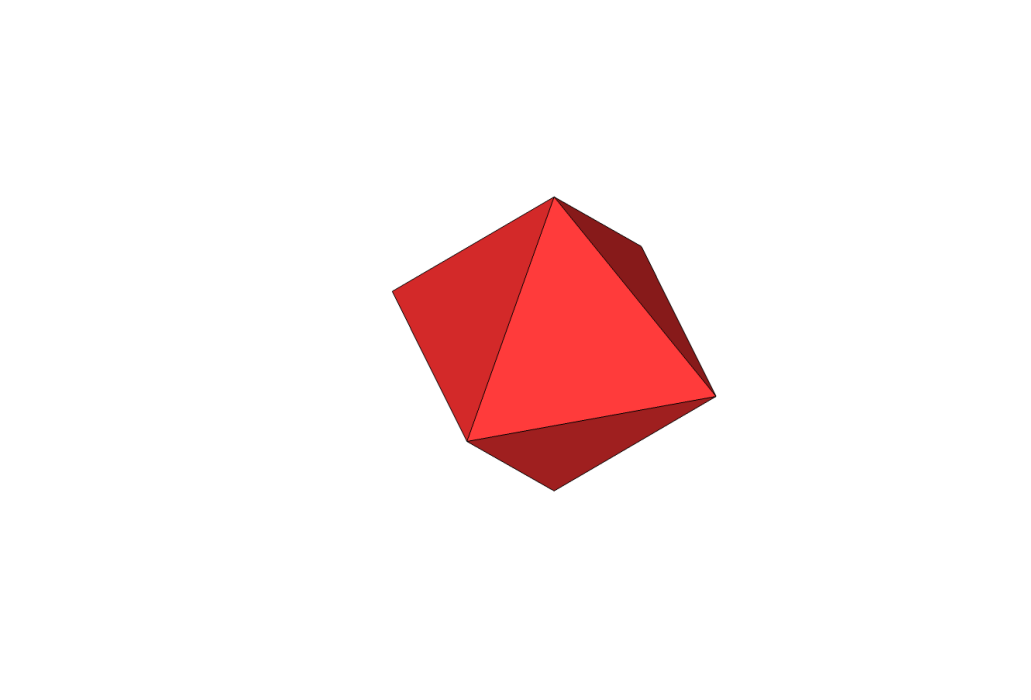

In [31]:
img = cv2.imread('../Week 6/week6_pictures/test.png')
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Переведем наше изображение в градации серого и заменим целые значения на вещественные типа float32 - это обязательные требования для дальнейшего использования встроенной функции детектора Харриса.
+ Hãy chuyển đổi hình ảnh của chúng ta sang thang độ xám và thay thế các giá trị nguyên bằng giá trị thực float32 - đây là những yêu cầu bắt buộc để tiếp tục sử dụng chức năng dò Harris tích hợp.

In [32]:
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img1 = np.float32(img1)

Теперь применим функцию cv2.cornerHarris(image,blockSize,ksize,k), где 

image - изображение (черно-белое и типа float32)

blockSize - размер соседства (т.е. для каждого пискеля учитывается размер блока blockSize*blockSize)

ksize - размер ядра Собеля, которое в cv2 используется для вычисления производных изображения по горизонтали и вертикали Ix и Iy в каждой точке изображения.
Параметр ksize может принимать значения 3, 5, 7 и т.д. (3x3, 5x5, ...). По мере увеличения размера все больше пикселей являются частью каждого процесса свертки, и края становятся более размытыми.

k - это эмпирическая константа, значения которой обычно 0.04 - 0.06. С большим k вы получите меньше ложных углов, но пропустите больше реальных углов (высокая точность), с меньшим k  получите намного больше углов, но пропустите меньше истинных углов, но получите много ложных (высокий отзыв).

Посмотрим на полученное изображение:

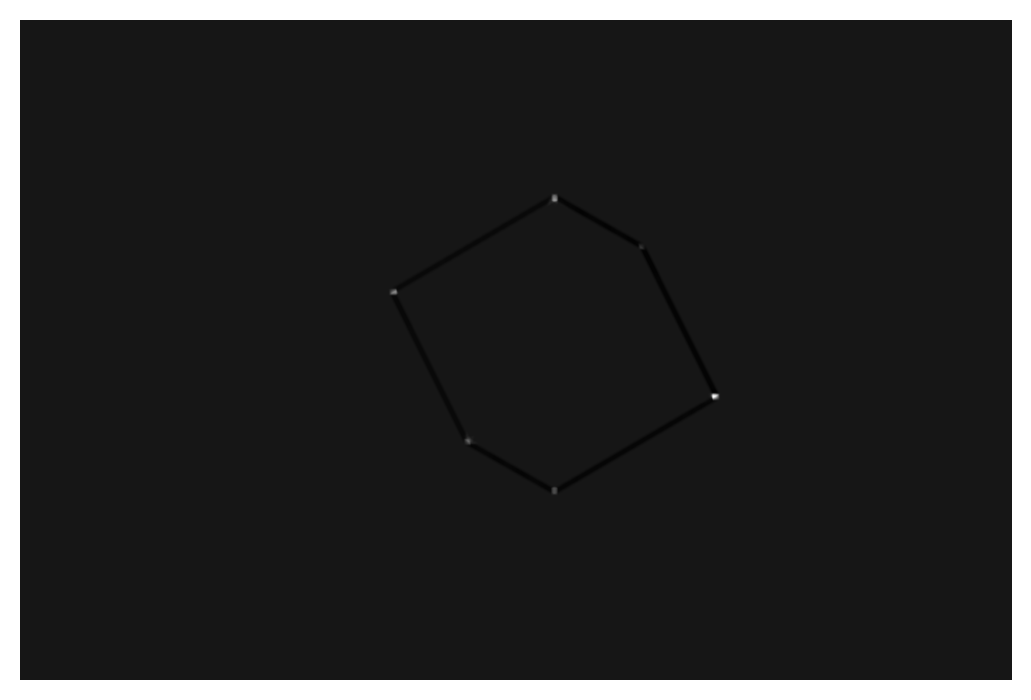

In [33]:
dst = cv2.cornerHarris(img1,10,3,0.04)
plt.axis('off')
plt.imshow(dst, cmap='gray')

Результат выполнения функции cv2.cornerHarris - некий массив с такой же размерностью, что и исходное изображение, в котором собраны вероятности "потенциальных" углов. 

Давайте растянем наш результат с помощью функции cv2.dilate, чтобы увеличить светлые области и посмотрим на полученный результат (карту «угловых точек»):

+ Kết quả của hàm cv2.cornerHarris là một mảng có cùng kích thước với hình ảnh ban đầu, chứa xác suất của các góc "tiềm năng".

+ Hãy kéo dài kết quả của chúng ta với cv2.dilate để phóng to các vùng sáng và xem kết quả (bản đồ "các điểm góc"):

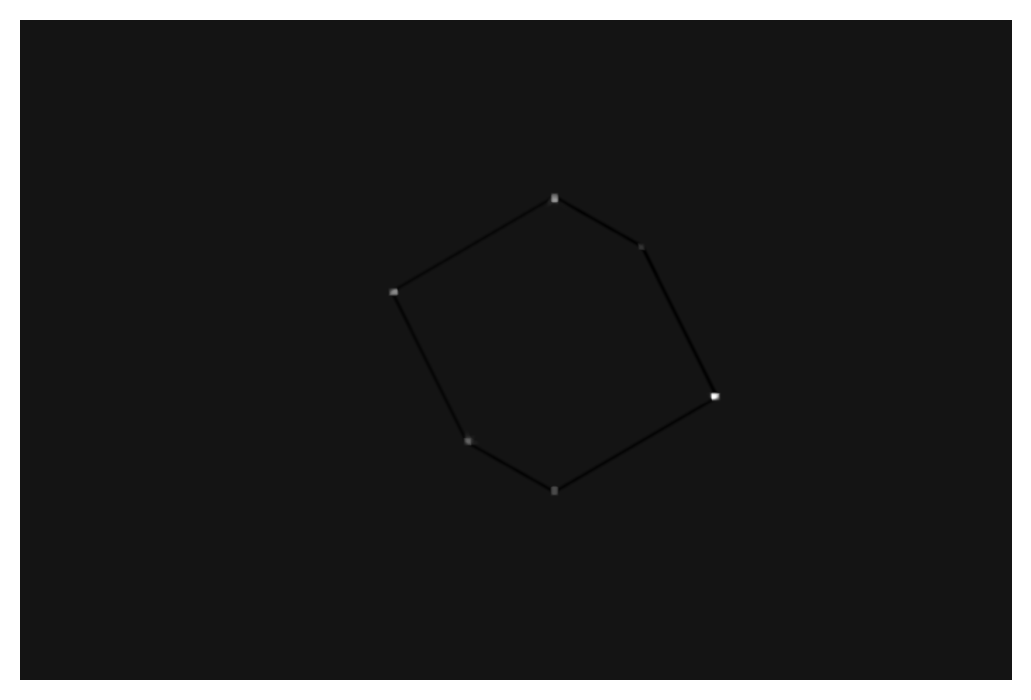

In [34]:
dst = cv2.dilate(dst,None)
plt.axis('off')
plt.imshow(dst, cmap='gray')

Осталось убрать значения меньше некого порогового (threshold) и наложить полученные угловые области на наше исходное изображение.

Threshold обычно определяется, как максимальное значение, умноженное на некий коэффициент, меньший единицы. Все , что меньше, останется в первоначальном виде, а то, что больше, можно окрасить в какой-то определенный цвет.

Коэффициент для определения threshold зависит от исходного изображения (чем меньше этот коэффициент, тем больше "потенциальных" углов мы увидим). Сейчас мы определим его равным 0.01 (выберем те, у которых вероятность отличается от мах не больше 1%), но самостоятельно рекомендуется попробовать другие величины.

+ Nó vẫn còn để loại bỏ các giá trị nhỏ hơn một ngưỡng (ngưỡng) nhất định và áp đặt các khu vực góc kết quả trên hình ảnh ban đầu của chúng tôi.

+ Ngưỡng thường được định nghĩa là giá trị lớn nhất nhân với một số thừa số nhỏ hơn một. Mọi thứ nhỏ hơn sẽ vẫn ở dạng ban đầu và thứ lớn hơn có thể được sơn bằng một màu nhất định.

+ Hệ số xác định ngưỡng phụ thuộc vào ảnh gốc (hệ số này càng nhỏ, chúng ta sẽ thấy càng nhiều góc "tiềm năng"). Bây giờ chúng tôi sẽ xác định nó bằng 0,01 (chúng tôi sẽ chọn những giá trị có xác suất khác với giá trị tối đa không quá 1%), nhưng bạn nên tự mình thử các giá trị khác.


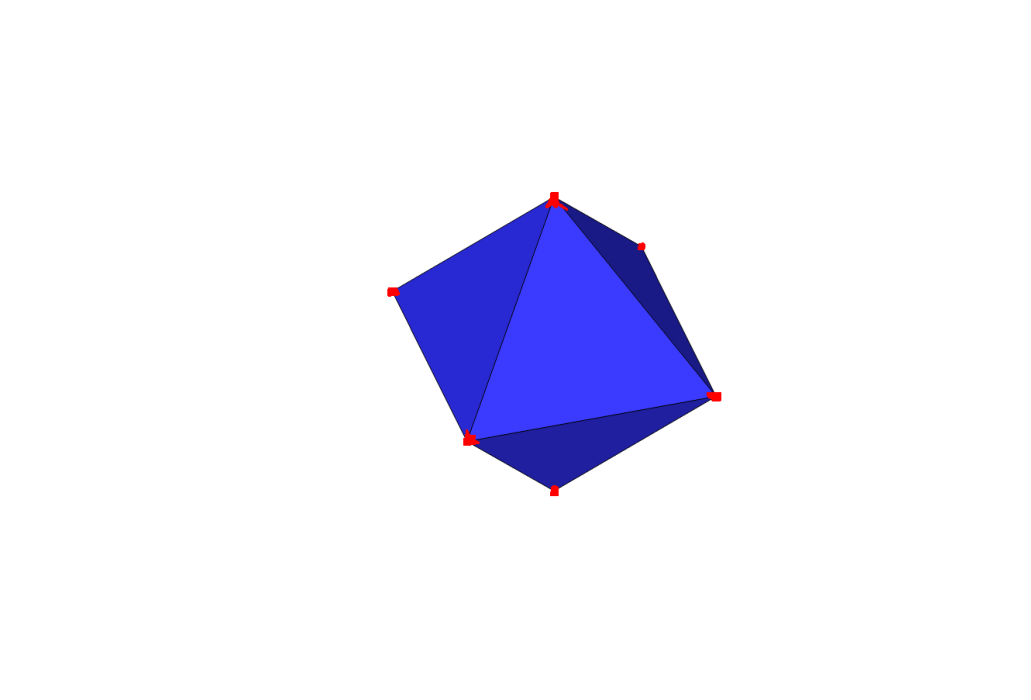

In [35]:
threshold = 0.001*dst.max()
img[dst>threshold]=[255,0,0] 
#[255,0,0] - области углов выделятся синим, [0,255,0] - зелёным, [0,0,255] - красным,
#[0,0,0] - чёрным, [255,255,255] - белым
plt.axis('off')
plt.imshow(img, cmap='gray')

Предлагается самостоятельно посмотреть, что метод Харриса инвариантен относительно поворота и не инвариантен к масштабированию. Для этого исходное изображение необходимо изменить с помощью, например, функций cv2.flip(img, -1) (0 - поворот относительно оси Х, 1 - Y, -1 - X и Y) или cv2.resize(img, (width_new, high_new))
+ Bạn nên tự mình chứng kiến ​​rằng phương pháp Harris là bất biến khi quay và không bất biến khi chia tỷ lệ. Để thực hiện việc này, hình ảnh gốc phải được thay đổi bằng cách sử dụng, chẳng hạn như các hàm cv2.flip(img, -1) (0 - xoay quanh trục X, 1 - Y, -1 - X và Y) hoặc cv2.resize (img, (width_new, high_new))

**Детектор Ши-Томаси**

Данный детектор во многом совпадает с детектором Харриса, но различается в вычислении меры отклика: алгоритм напрямую вычисляет значение , поскольку делается предположение, что поиск углов будет более стабильным.

Рассмотрим применение детектора Ши Томаса средствами Python. 

Считаем исходное изображение и сделаем его монохромным.

**Máy dò Shi-Tomasi**

+ Máy dò này phần lớn giống với máy dò Harris, nhưng khác ở cách tính thước đo phản hồi: thuật toán tính trực tiếp giá trị của , vì người ta cho rằng việc tìm kiếm các góc sẽ ổn định hơn.

+ Cân nhắc sử dụng trình phát hiện Shea Thomas bằng các công cụ Python.

+ Chúng tôi xem xét hình ảnh gốc và làm cho nó đơn sắc.

In [36]:
img = cv2.imread('../Week 6/week6_pictures/test.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

Применим функцию cv2.goodFeaturesToTrack(image,maxCorners, qualityLevel, minDistance), где

image - изображение (черно-белое)

maxCorners - максимальное количество углов для поиска( если углов меньше, функция применится к "сильнейшим" углам)

qualityLevel - уровень качества, характеризующий минимальное качество угла на изображении (0-1)

minDistance - минимальная дистанция между углами


+ Hãy áp dụng hàm cv2.goodFeaturesToTrack(image,maxCorners, qualityLevel, minDistance), trong đó

hình ảnh - hình ảnh (đen trắng)

+ maxCorners - số lượng góc tối đa để tìm kiếm (nếu có ít góc hơn, chức năng sẽ được áp dụng cho các góc "mạnh nhất")

+ qualityLevel - mức chất lượng đặc trưng cho chất lượng tối thiểu của góc trên ảnh (0-1)

+ minDistance - khoảng cách tối thiểu giữa các góc

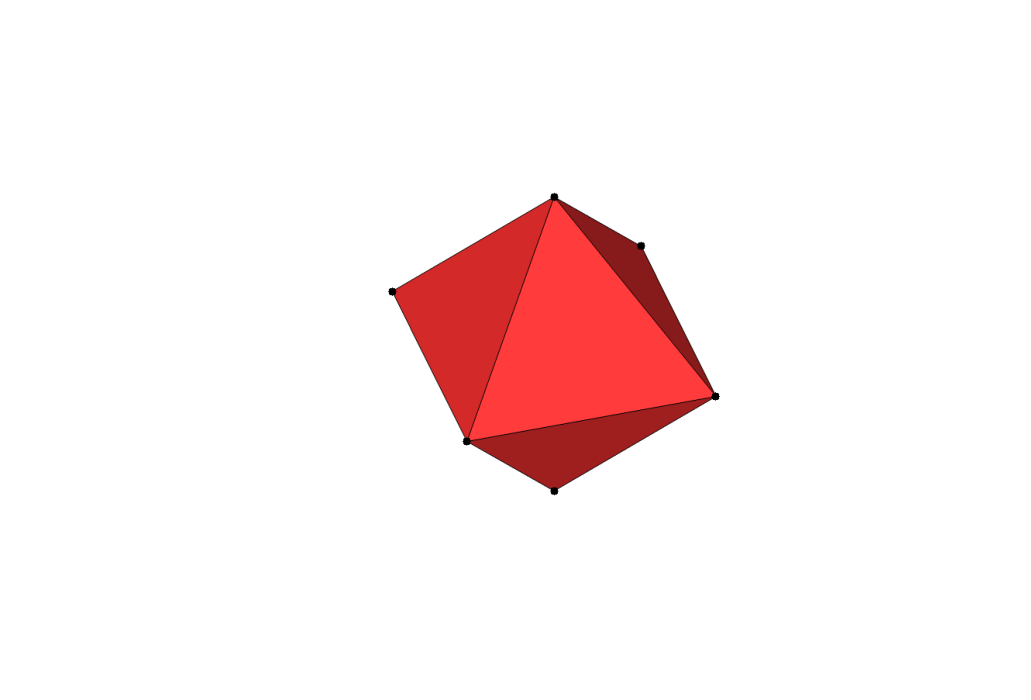

In [37]:
corners = cv2.goodFeaturesToTrack(gray, 6, 0.01, 5)
corners = np.int0(corners) # преобразуем в целые
for i in corners:
    x, y = i.ravel() # определяем координаты угла
    cv2.circle(img, (x, y), 5, [0,0,0], -1) # рисуем круг на исходном изображении, в указанном месте, 
                                        # указанного радиуса (5), цвета с заливкой (-1)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**Преобразование Хаффа**

Это метод обнаружения прямых и кривых линий на изображениях. 
Используется в автопилотах Tesla.


Загрузим изображение и переведем его в градации серого:

**Chuyển đổi Huff**

+ Đó là một phương pháp để phát hiện các đường thẳng và đường cong trong ảnh.
Được sử dụng trong máy lái tự động Tesla.

+ Tải hình ảnh và chuyển đổi nó thành thang độ xám:

In [38]:
mpl.rcParams['figure.dpi'] = 100

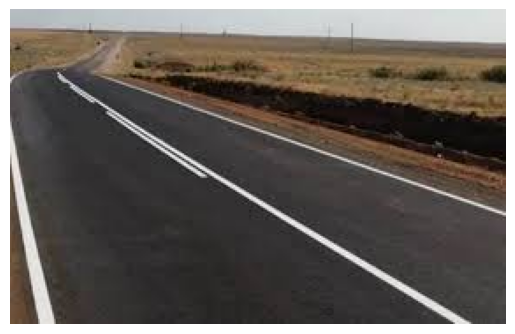

In [39]:
img = cv2.imread("/home/tuandinh/Desktop/Image-Processing-in-ITMO/Week 6/week6_pictures/road.jpeg")
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Определим границы изображения с помощью функции cv2.Canny(image, threshold1, threshold2), где в качестве аргументов используется следующее:

image - исходное изображение (черно-белое)

threshold1 - верхнее пороговое значение градиента интенсивности,

threshold2 - нижнее пороговое значение градиента интенсивности.

Эта функция, как видно из названия, использует детектор границ Кенни.  



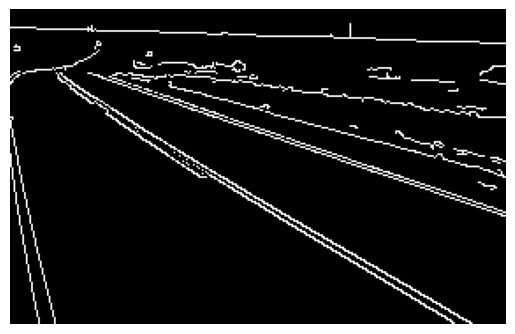

In [41]:
edges = cv2.Canny(gray, 150, 300)
plt.axis('off')
plt.imshow(edges, cmap='gray')

Можно самостоятельно поэкспериментировать с пороговыми значениями. Например, взять среднее значение интенсивности пикселей изображения (v = np.median(gray)) и вычислить отклонения от него с некоторым эмпирическим коэффициентом равным 0.33 по формулам: threshold1 = int(max(0, (1.0 - 0.33) * v))
threshold2 = int(min(255, (1.0 + 0.33) * v))

Теперь применим функцию cv2.HoughLinesP() для определения линий. Используем в качестве аргументов следующее: изображение границ, maxLineGap - максимальное расстояние между линиями, 
minLineLength - минимальная длина линии, rho и theta - разрешение в пикселях и радианах, соответственно.
И нарисуем полученные линии:

+ Bạn có thể tự mình thử nghiệm với các giá trị ngưỡng. Ví dụ: lấy giá trị trung bình của cường độ pixel hình ảnh (v = np.median(xám)) và tính độ lệch so với giá trị đó với một số hệ số thực nghiệm bằng 0,33 bằng cách sử dụng các công thức: ngưỡng1 = int(max(0, ( 1.0 - 0.33) * v))
ngưỡng2 = int(tối thiểu(255, (1,0 + 0,33) * v))

+ Bây giờ, hãy sử dụng hàm cv2.HoughLinesP() để xác định các đường. Chúng tôi sử dụng các đối số sau: hình ảnh đường viền, maxLineGap - khoảng cách tối đa giữa các dòng,
minLineLength - độ dài dòng tối thiểu, rho và theta - độ phân giải tương ứng tính bằng pixel và radian.
Và vẽ các đường kết quả:

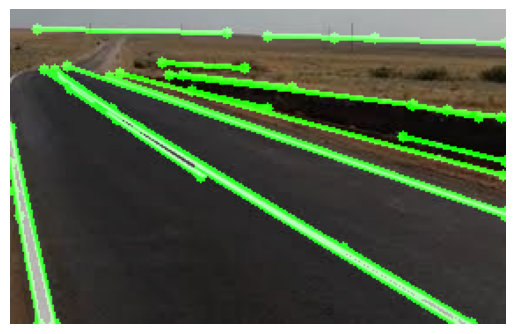

In [42]:
lines = cv2.HoughLinesP(edges, rho=1.0,theta=np.pi/180,threshold=20,minLineLength=30,maxLineGap=10)
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) #создание пустого изображение с той же длиной, высотой, спектром цветов как у img
line_color = [0, 255, 0]
line_thickness = 2
dot_color = [0, 255, 0]
dot_size = 3

for line in lines: #цикл задаёт отрезки
    for x1, y1, x2, y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.circle(line_img, (x1, y1), dot_size, dot_color, -1)
        cv2.circle(line_img, (x2, y2), dot_size, dot_color, -1)
final = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0) 
#накладываем изображение с отрезками на начальное изображение
# 0.8 - alpha(задаёт вес первого изображения)
# 1.0 - beta(задаёт вес второго изображения)
# 0.0 - gamma(скалярная величина добавляемая к каждому изображению)
# Формула addWeighted: final = img*alpha + line_iplt.axis('off')
plt.axis('off')
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

**Дескриптор SIFT (Scale-Invariant Feature Transform)**

Загружаем исходное изображение, как GRAYSCALE:

**Bộ mô tả SIFT (Biến đổi tính năng bất biến theo tỷ lệ)**

+ Đang tải hình ảnh gốc dưới dạng GRAYSCALE:

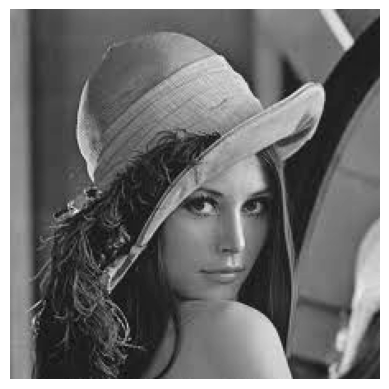

In [43]:
img = cv2.imread('/home/tuandinh/Desktop/Image-Processing-in-ITMO/Week 6/week6_pictures/Lena.jpg', cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(img, cmap='gray')

Создадим объект-алгоритм SIFT и найдём ключевые точки с помощью sift.detectAndCompute(img).

Каждая ключевая точка - это некая структура, которая имеет множество атрибутов, таких, как координаты (x, y), размер значимой окрестности, угол, определяющий ее ориентацию, сила ключевых точек и т. д. 

А дескриптор - это некий набор чисел для поиска ключевых точек на основе освещения, размера и направления, он хранит гистограмму ориентированных градиентов для области вокруг каждой ключевой точки.

Для примера выведем значения аттрибутов, которые пригодятся в дальнейшем, для нескольких ключевый точек.

+ Hãy tạo một đối tượng thuật toán SIFT và tìm các điểm chính bằng cách sử dụng sift.detectAndCompute(img).

+ Mỗi điểm chính là một loại cấu trúc có nhiều thuộc tính, chẳng hạn như tọa độ (x, y), kích thước của một vùng lân cận quan trọng, góc xác định hướng của nó, độ mạnh của các điểm chính, v.v.

+ Và một bộ mô tả là một tập hợp các số để tìm các điểm chính dựa trên ánh sáng, kích thước và hướng, nó lưu trữ biểu đồ các độ dốc được định hướng cho khu vực xung quanh mỗi điểm chính.

+ Ví dụ: hãy hiển thị các giá trị thuộc tính sẽ hữu ích trong tương lai cho một số điểm chính.

In [44]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img, None)
for i in range(0,3):
  print("SIFT Keypoint:",i)
  print("Координаты ",kp[i].pt,"Размер ", kp[i].size, "Угол ", kp[i].angle)


SIFT Keypoint: 0
Координаты  (15.591696739196777, 182.9761505126953) Размер  2.3962228298187256 Угол  217.63388061523438
SIFT Keypoint: 1
Координаты  (16.123144149780273, 153.87867736816406) Размер  5.678529739379883 Угол  179.068359375
SIFT Keypoint: 2
Координаты  (16.41448402404785, 207.24119567871094) Размер  2.287032127380371 Угол  174.12124633789062


Воспользуемся встроенной функцией cv2.drawKeyPoints(), которая рисует окружности вокруг найденных ключевых точек. В качестве параметров этой функции указываем наше изображение, множество контрольных точек, цвет, флаг (можно не указывать), если хотим, чтобы окружность имела размер ключевой точки и ориентацию (как мы знаем, направление ключевой точки вычисляется исходя из направлений градиентов точек, соседних с ней)
+ Hãy sử dụng hàm cv2.drawKeyPoints() tích hợp sẵn để vẽ các vòng tròn xung quanh các điểm chính được tìm thấy. Là tham số của chức năng này, chúng tôi chỉ định hình ảnh, tập hợp các điểm kiểm soát, màu sắc, cờ (bạn không thể chỉ định nó), nếu chúng tôi muốn vòng tròn có kích thước của điểm chính và hướng (như chúng ta biết, hướng của điểm chính được tính dựa trên hướng của độ dốc của các điểm liền kề với cô ấy)

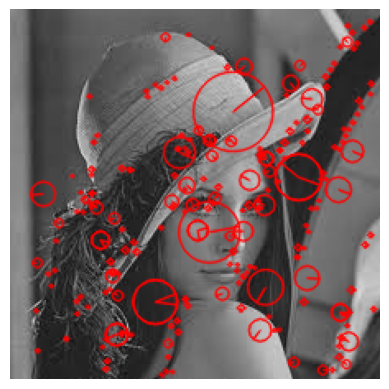

In [45]:
img_kp = cv2.drawKeypoints(img,kp,np.array([]),[255,0,0],cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.axis('off')
plt.imshow(img_kp, cmap='gray')

Давайте используем дескриптор SIFT для нахождения одного изображения в другом. Например, найдем в потоке машин определенный номерной знак. Усложним - перевернем знак.

Загрузим изображения в переведем их в градации серого:

In [46]:
img_1 = cv2.imread("/home/tuandinh/Desktop/Image-Processing-in-ITMO/Week 6/week6_pictures/Num.jpg")
img_2 = cv2.imread("/home/tuandinh/Desktop/Image-Processing-in-ITMO/Week 6/week6_pictures/trafic_jam.jpg")

In [47]:
img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

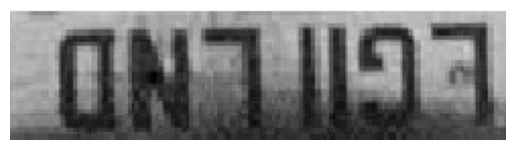

In [48]:
plt.axis('off')
plt.imshow(img1, cmap='gray')

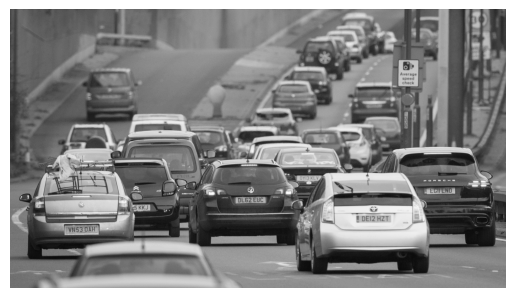

In [49]:
plt.axis('off')
plt.imshow(img2, cmap='gray')

C помощью дескриптора SIFT находим контрольные точки и дескрипторы:

In [50]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None) 
kp2, des2 = sift.detectAndCompute(img2, None) 

Нам необходимо сопоставить контрольные точки и соответсвующие дескрипторы одного изображения с другим. Для этого можно использовать BFMatcher (Brute-force matcher):

In [51]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=True) 
#crossCheck=false - совпадения вида один ко многим, crossCheck=true - совпадения вида один к одному
matches = bf.match(des1,des2)

Полученные совпадения в качестве аттрибутов имеют расстояние (по сути - это расстояние между двумя векторами, в нашем случае евклидово), индекс, соответсвующий первому изображению, индекс, соответсвующий второму изображению.

Отсортируем совпадения от лучшего к худшему в зависимости от аттрибута distance (чем меньше, тем лучше).

+ Các trận đấu kết quả có các thuộc tính khoảng cách (trên thực tế, khoảng cách giữa hai vectơ, trong trường hợp của chúng tôi là Euclidean), chỉ số tương ứng với hình ảnh đầu tiên, chỉ số tương ứng với hình ảnh thứ hai.

+ Sắp xếp các kết quả phù hợp từ tốt nhất đến kém nhất tùy thuộc vào thuộc tính khoảng cách (càng nhỏ càng tốt).

In [52]:
matches = sorted(matches, key = lambda x:x.distance) 
print('Количество совпадений ', len(matches))
for i in range(0,3): #выведем первые 3 
  print('Расстояние ',matches[i].distance,'Индекс 1 ',matches[i].trainIdx,'Индекс 2 ', matches[i].queryIdx)

Количество совпадений  76
Расстояние  317.0 Индекс 1  7175 Индекс 2  1
Расстояние  409.0 Индекс 1  7017 Индекс 2  60
Расстояние  413.0 Индекс 1  6861 Индекс 2  90


Выведем полученный результат для лучших 5 совпадений с помощью функции cv2.drawMatches, где укажем исходные изображения, контрольные точки (на этом шаге уже можем вернуться к исходным цветным).

+ Hãy hiển thị kết quả cho 5 trận đấu tốt nhất bằng cách sử dụng chức năng cv2.drawMatches, trong đó chúng tôi chỉ ra các hình ảnh gốc, các điểm kiểm soát (ở bước này, chúng tôi đã có thể quay lại các màu gốc).

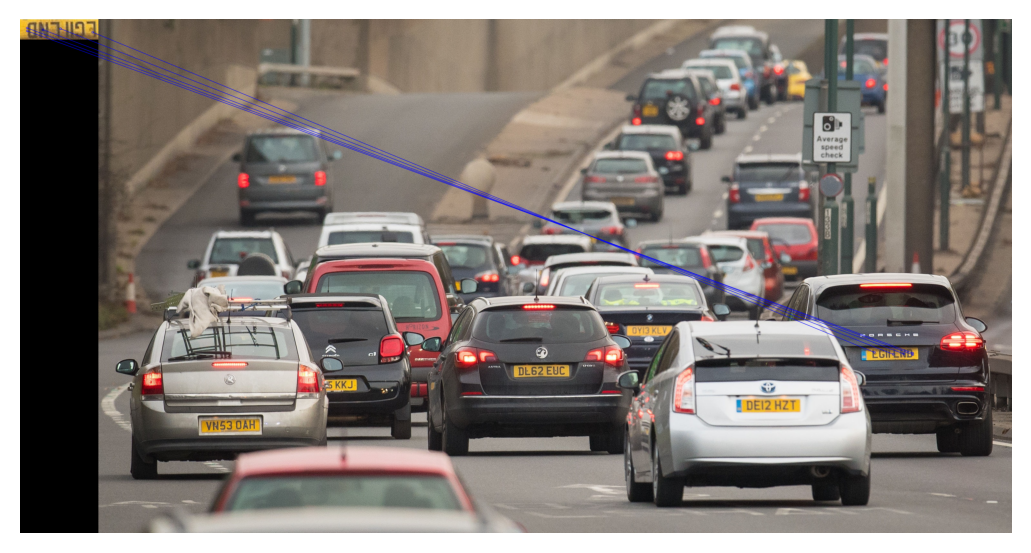

In [53]:
matching_result = cv2.drawMatches(img_1, kp1, img_2, kp2, matches[:5], None, [255,0,0], flags=2)
mpl.rcParams['figure.dpi'] = 200
plt.axis('off')
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

А теперь попробуем сопоставить два изображения, используя дескриптор SIFT.

Загрузим изображения в переведем их в градации серого:

+ Bây giờ, hãy thử khớp hai hình ảnh bằng bộ mô tả SIFT.

+ Hãy tải các hình ảnh vào và chuyển đổi chúng thành thang độ xám:

In [54]:
img_1 = cv2.imread("week6_pictures/tt_2.jpg")
img_2 = cv2.imread("week6_pictures/tt_1.jpg")
img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

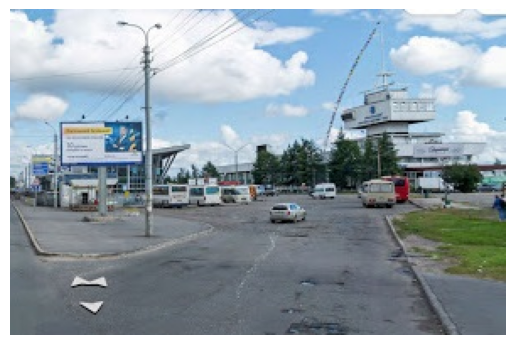

In [55]:
mpl.rcParams['figure.dpi'] = 100
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

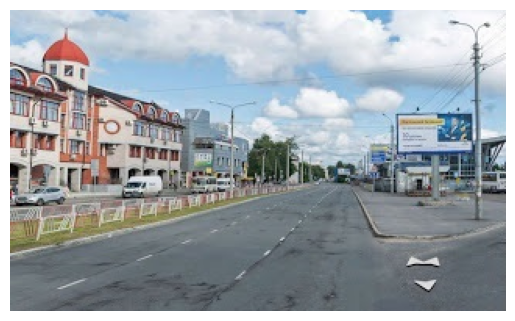

In [56]:
plt.axis('off')
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))

C помощью дескриптора SIFT находим контрольные точки и дескрипторы:

In [57]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None) 
kp2, des2 = sift.detectAndCompute(img2, None) 

Нам необходимо сопоставить контрольные точки и соответсвующие дескрипторы одного изображения с другим. Для этого можно использовать BFMatcher (Brute-force matcher):

In [58]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=True) 
#crossCheck=false - совпадения вида один ко многим, crossCheck=true - совпадения вида один к одному
matches = bf.match(des1,des2)

Отсортируем совпадения от лучшего к худшему в зависимости от аттрибута distance (чем меньше, тем лучше), по сути это расстояние между двумя векторами.

In [59]:
matches = sorted(matches, key = lambda x:x.distance) 
print('Количество совпадений ', len(matches))
for i in range(0,3): #выведем первые 3 
  print('Расстояние ',matches[i].distance,'Индекс 1 ',matches[i].trainIdx,'Индекс 2 ', matches[i].queryIdx)


Количество совпадений  166
Расстояние  17.0 Индекс 1  405 Индекс 2  80
Расстояние  17.0 Индекс 1  419 Индекс 2  94
Расстояние  19.0 Индекс 1  391 Индекс 2  63


Посмотрим, что у нас получилось для самых лучших совпадений (первые 99):

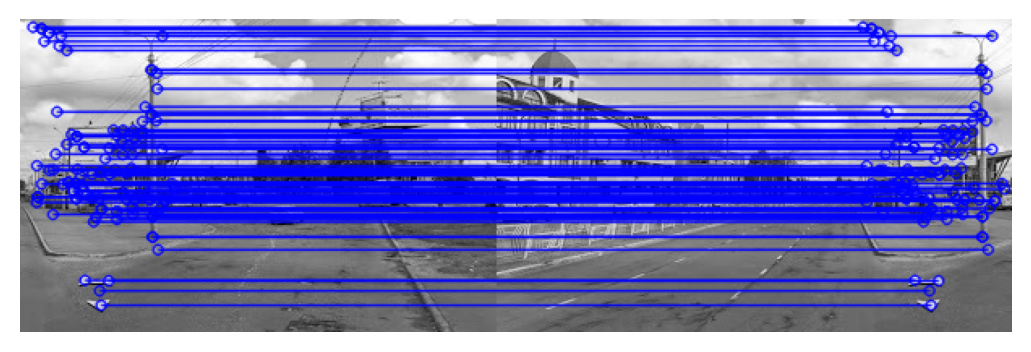

In [60]:
matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:99], None,[255,0,0], flags=2)
mpl.rcParams['figure.dpi'] = 200
plt.axis('off')
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

Теперь попробуем определить некую матрицу трансформации, которая переводит набор контрольных точек и и их дескрипторов одного изображения в аналогичный набор другого изображения. 

Создадим новые наборы вещественного типа float32, в которых поменяем координаты контрольных точек (для первого изображения подставим координаты второго и наоборот). Но сделаем это только для совпавших контрольных точек, т.е. тех, что есть в matches.

А матрицу трансформации H найдем, используя подход RANSAC (о нем подробно рассказывалось в лекции) и функцию cv2.findHomography, в которую как раз и подадим наши новые наборы.

+ Bây giờ, hãy cố gắng xác định một ma trận chuyển đổi nhất định để dịch một tập hợp các điểm kiểm soát và bộ mô tả của chúng từ một hình ảnh thành một tập hợp tương tự của một hình ảnh khác.

+ Hãy tạo các tập hợp kiểu thực float32 mới, trong đó chúng ta sẽ thay đổi tọa độ của các điểm điều khiển (đối với hình ảnh đầu tiên, chúng ta sẽ thay thế tọa độ của hình ảnh thứ hai và ngược lại). Nhưng hãy chỉ làm điều này cho các điểm kiểm soát phù hợp, tức là những người trong các trận đấu.

+ Và chúng ta sẽ tìm ma trận biến đổi H bằng cách sử dụng phương pháp RANSAC (nó đã được mô tả chi tiết trong bài giảng) và hàm cv2.findHomography, trong đó chúng ta sẽ cung cấp các tập hợp mới của mình.

In [61]:
new1 = np.float32([kp1[m.queryIdx].pt for m in matches]) # координаты контрольной точки для 1-ого изображения
new2 = np.float32([kp2[m.trainIdx].pt for m in matches]) # координаты контрольной точки для 2-ого изображения
H, status = cv2.findHomography(new1, new2, cv2.RANSAC, 4.0)

Итак все готово, чтобы получить результирующее изображение. Мы ожидаем, что первое изображение сместится вправо, а второе наложиться на него , сдвинувшись влево.

Так и сделаем: применим к первому нашу матрицу трансформации, а сверху наложим второе.

Не будем концентрироваться на вычислении размера результирующего изображения. Грубо допустим, что оно будет в ширину явно меньше суммы исходных (они же должны наложиться со сдвигом), а в высоту не больше максимальной высоты двух исходных.

Обратите внимание, что на последней шаге мы использум изначальные изображения (не в оттенках серого).

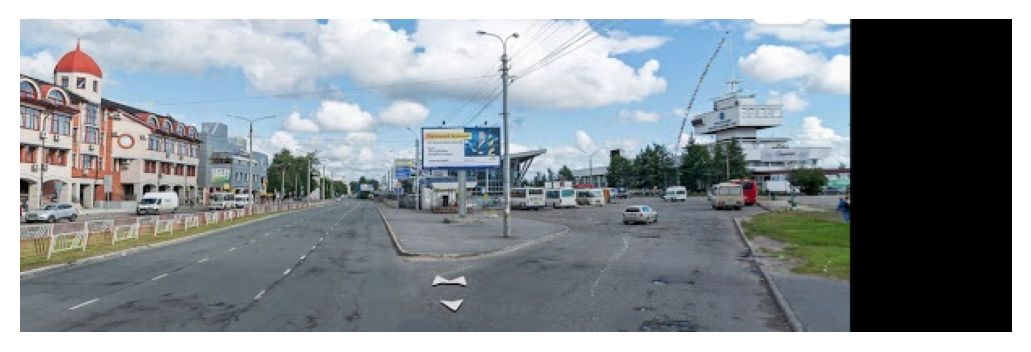

In [62]:
width = img1.shape[1] + img2.shape[1] 
height = max(img1.shape[0],img2.shape[0])
result = cv2.warpPerspective(img_1, H, (width,height)) #Трансформируем 1-ое изображение
result[0:img2.shape[0], 0:img2.shape[1]] = img_2      #Накладываем 2-ое изображение в крайний левый угол
mpl.rcParams['figure.dpi'] = 200
plt.axis('off')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

Получился ожидаемый результат (черная область появилась из-за грубой оценки размеров).